<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/deagwon/Dacon_satellite_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 305 kB in 1s (443 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Selecting previously unselected package libproj-dev:amd64.
Prepari

     |████████████████████████████████| 133.1MB 29kB/s 
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756026 sha256=ceb95cba3b40fa52bc004b5b6e6021d381cee679566bd1625785faffd9594b53
  Stored in directory: /tmp/pip-ephem-wheel-cache-3s4l0dod/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
  Found existing installation: basemap 1.1.0
    Uninstalling basemap-1.1.0:
      Successfully uninstalled basemap-1.1.0


In [0]:
# style 설정
plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

In [5]:
tf.__version__

'2.2.0-rc3'

## 데이터 받아오기

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_add.npy')
train_orbit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_orbit.npy')
#test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')

In [8]:
train.shape

(76345, 40, 40, 15)

In [9]:
#데이터 Random Shuffle
'''## EDA를 위해서 셔플 진행 X

index = np.arange(train.shape[0])
np.random.shuffle(index)

#train set shuffle
train = train[index,:,:,:]
gc.collect()
train.shape

#test set shuffle
train_orbit = train_orbit[index,:]
gc.collect()
train_orbit.shape
'''

'## EDA를 위해서 셔플 진행 X\n\nindex = np.arange(train.shape[0])\nnp.random.shuffle(index)\n\n#train set shuffle\ntrain = train[index,:,:,:]\ngc.collect()\ntrain.shape\n\n#test set shuffle\ntrain_orbit = train_orbit[index,:]\ngc.collect()\ntrain_orbit.shape\n'

## Orbit분석하기

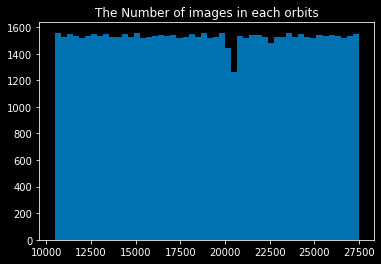

'\n모든 orbit속 이미지 숫자가 동일하지 않음,  \n2개(?)의 orbit에서 다른 orbit보다 적은 수의 이미지가 존재.  \n날짜 데이터로 변환할 때 이를 고려할것.\n'

In [10]:
# train_orbit의 histogram

plt.hist(train_orbit[:,0], bins = 50)
plt.title('The Number of images in each orbits', color = 'white')
plt.show()
'''
모든 orbit속 이미지 숫자가 동일하지 않음,  
2개(?)의 orbit에서 다른 orbit보다 적은 수의 이미지가 존재.  
날짜 데이터로 변환할 때 이를 고려할것.
'''


In [11]:
# train_orbit을 이용하여 연도, 월, 날짜 시간 데이터 생성
# DataFrame으로 변환
train_orbit = pd.DataFrame(train_orbit)
train_orbit.columns = ['orbit_number', 'order']
# orbit_number :  위성이 사용되기 시작한 이후로 몇 번째 지구를 돌았는지 나타내는 수(orbit 번호)
# order : 해당 orbit에서 몇 번째 subset인지를 나타내는 수입니다. orbit별로 subset의 개수는 다를 수 있음 (subset 번호)
train_orbit.head()

orbit_number  order
0         10462      1
1         10462      2
2         10462      3
3         10462      4
4         10462      5

train.zip
-     2016~2018 년 관측된 자료 (76,345개)
-     2016년 자료: orbit 번호 010462 ~ 016152 (25,653개)
-     2017년 자료: orbit 번호 016154 ~ 021828 (25,197개)
-     2018년 자료: orbit 번호 021835 ~ 027509 (25,495개)

test.zip 
-     2019년 관측된 자료 (2,416개)

In [0]:
# year column 추가
train_orbit['year'] = 0
train_orbit.loc[train_orbit.orbit_number <= 16152,'year'] = 2016
train_orbit.loc[(16152 <= train_orbit.orbit_number) & (train_orbit.orbit_number <= 21828), 'year'] = 2017
train_orbit.loc[(21828 < train_orbit.orbit_number) & (train_orbit.orbit_number <= 27509), 'year'] = 2018

In [13]:
train_orbit.year.value_counts()

2016    25650
2018    25495
2017    25200
Name: year, dtype: int64

In [0]:
# month column 추가
train_orbit['month'] = 0
train_orbit.loc[train_orbit.loc[:,'year'] == 2016,'month'] = ((16152 - train_orbit.loc[train_orbit.loc[:,'year'] == 2016,'orbit_number'])/(16152 - 10462) * 12)
train_orbit.loc[train_orbit.loc[:,'year'] == 2017,'month'] = ((21828 - train_orbit.loc[train_orbit.loc[:,'year'] == 2017,'orbit_number'])/(21828 - 16152) * 12)
train_orbit.loc[train_orbit.loc[:,'year'] == 2018,'month'] = ((27509 - train_orbit.loc[train_orbit.loc[:,'year'] == 2018,'orbit_number'])/(27509 - 21828) * 12)

train_orbit.month = train_orbit.month.apply(np.ceil)# 올림
train_orbit.month[train_orbit.month == 0] = 1 # 가장 처음 다오는 orbit은 1월로

In [15]:
train_orbit.head()

orbit_number  order  year  month
0         10462      1  2016   12.0
1         10462      2  2016   12.0
2         10462      3  2016   12.0
3         10462      4  2016   12.0
4         10462      5  2016   12.0

In [16]:
train.shape

(76345, 40, 40, 15)

In [17]:
train_orbit.shape

(76345, 4)

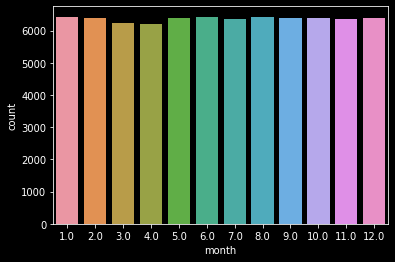

In [0]:
sns.countplot(train_orbit.month)
plt.show()


In [0]:
train_orbit.month.value_counts()

1.0     6431
6.0     6422
8.0     6412
10.0    6390
9.0     6385
2.0     6382
12.0    6379
5.0     6377
7.0     6370
11.0    6354
3.0     6240
4.0     6203
Name: month, dtype: int64

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train[1223]

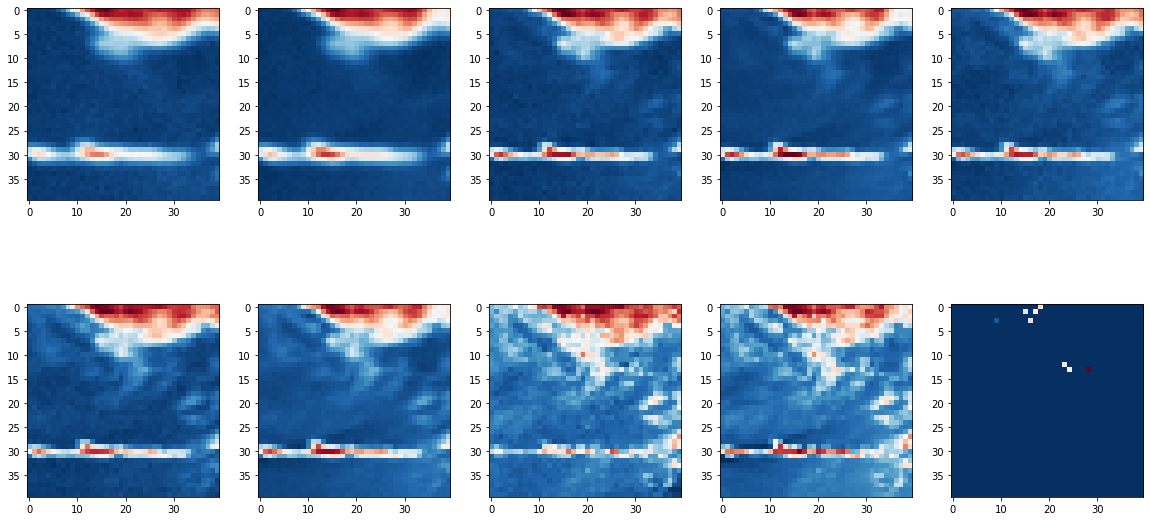

In [0]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [0]:
image_sample.shape

(40, 40, 15)

# 픽셀 단위로 EDA
Pandas 를 사용할 경우 메모리 초과  
numpy로 진행

특히 scatterplot을 그릴 때 메모리 소비가 증가하므로, 하나씩 그리기  
그래도 안되서 데이터 타입을 np.float16으로 변경

In [18]:
train_numeric = np.zeros((train.shape[0] * 40 * 40 ,5), np.float16)
train_numeric[:,0] = train[:,:,:,9].reshape(-1) # land type
train_numeric[:,1] = train[:,:,:,10].reshape(-1) # GMI longitude
train_numeric[:,2] = train[:,:,:,11].reshape(-1) # GMI latitude
train_numeric[:,3] = train[:,:,:,14].reshape(-1) #  precipication
train_numeric[train_numeric[:,3]<0,3]= 0## Null값은 모두 0으로 초기화

for i,month in enumerate(train_orbit.month.values):
    train_numeric[i*1600 : (i+1)*1600,4]  = month # Month

gc.collect()

5940

* Precipitation vs GMI_latitude

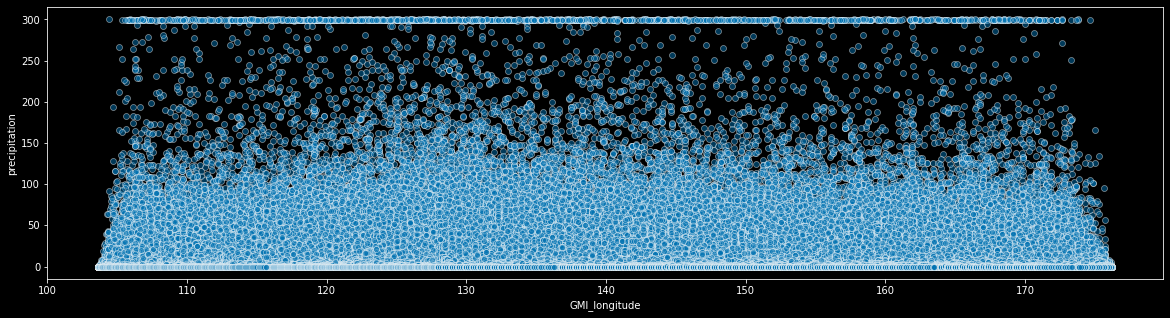

2515

In [0]:
plt.figure(figsize = (20,5))
sns.scatterplot(train_numeric[:,1],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('GMI_longitude')
plt.show()
gc.collect()

* Precipitation vs GMI_longitude

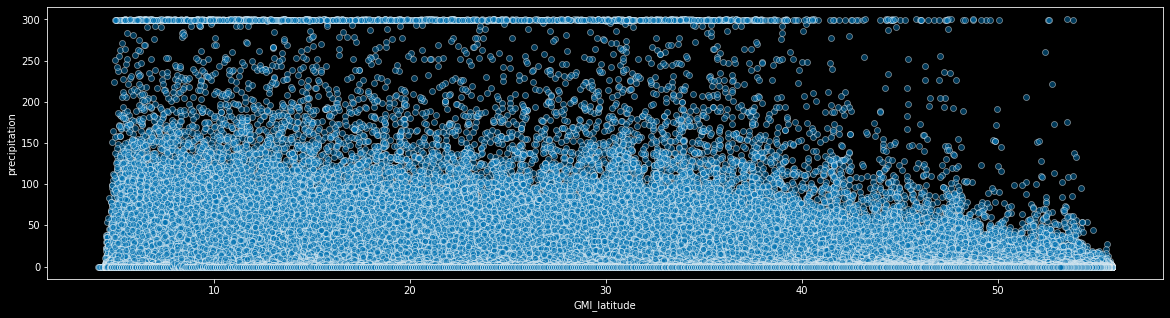

2341

In [0]:
plt.figure(figsize = (20,5))
sns.scatterplot(train_numeric[:,2],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('GMI_latitude')
plt.show()
gc.collect()

* Precipitation vs Land type

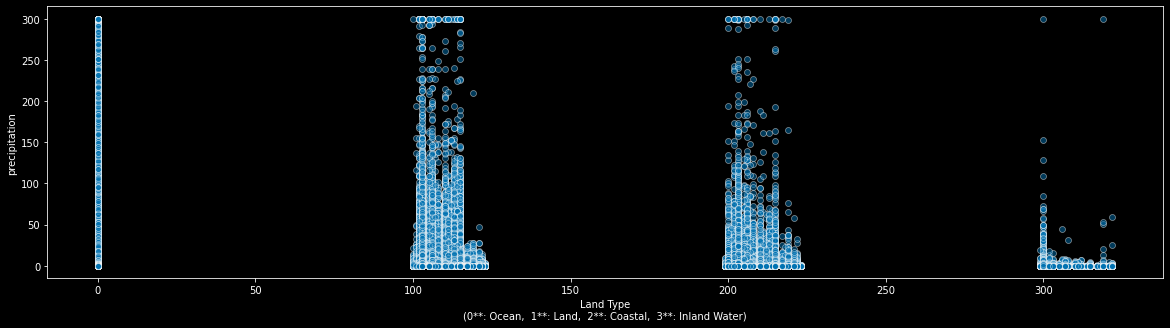

2457

In [0]:
plt.figure(figsize = (20,5))
sns.scatterplot(train_numeric[:,0],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('Land Type\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')
plt.show()
gc.collect()

### land_type별 강수 비율을 시각화
1. ladn_type ( 0 ~ 100, 100 ~ 200, 200 ~ 300, 300 ~) 으로 나누기
2. 강수구간 (0 ~ 50, 50 ~ 100, 100 ~ 150, 150 ~ 200, 250 ~ 300) 5개의 band로 묶기
3. (강수구간의 count / land_type count) * 100 계산하기
4. heatmap으로 표현하기

1. 월별 강수량

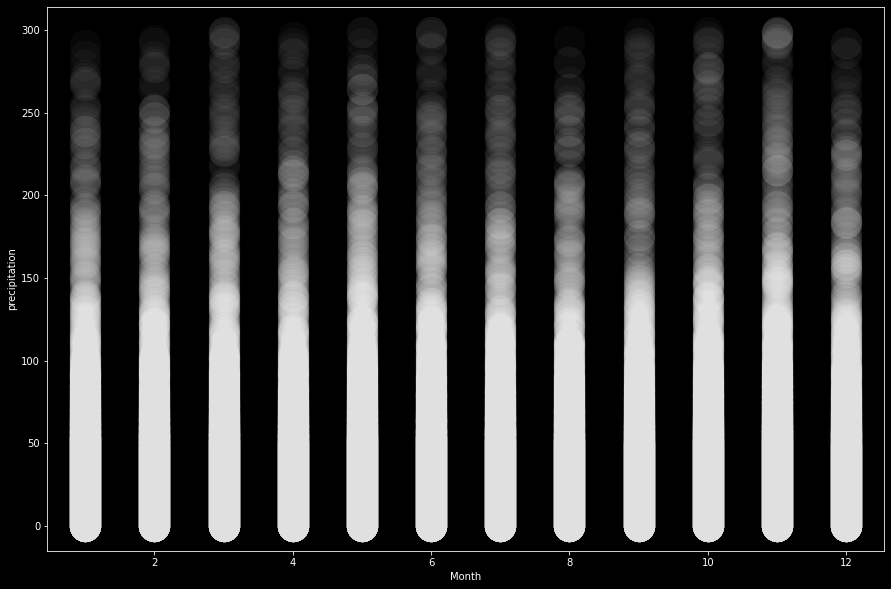

2399

In [0]:
#강수량이 0과 300일때를 제외하고 pricitication vs month의 scatterplot 그리기

plt.figure(figsize = (15,10))
sns.scatterplot(x = train_numeric[((train_numeric[:,3] > 0) & (train_numeric[:,3] < 299)), 4],
                y = train_numeric[((train_numeric[:,3] > 0) & (train_numeric[:,3] < 299)), 3],
                alpha = 0.03,
                s = 1000,
                linewidth=0,
                color = 'white'
                )


plt.ylabel('precipitation')
plt.xlabel('Month')
plt.show()
gc.collect()

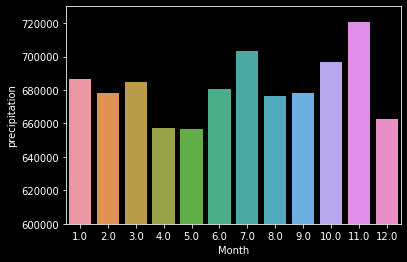

3355

In [0]:
# 강수량 > 0.1 일때 month 별 countplot
sns.countplot(train_numeric[(train_numeric[:,3] >= 0.1), 4])
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.ylim(600000,730000)
plt.show()
gc.collect()

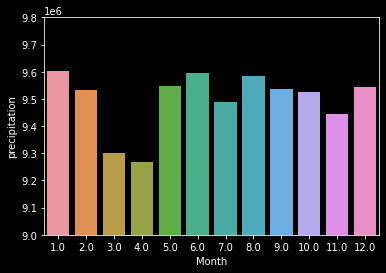

3421

In [0]:
# 강수량 < 0.1 일때 month 별 countplot
sns.countplot(train_numeric[(train_numeric[:,3] < 0.1), 4])
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.ylim(0.9e7,0.98e7)
plt.show()
gc.collect()

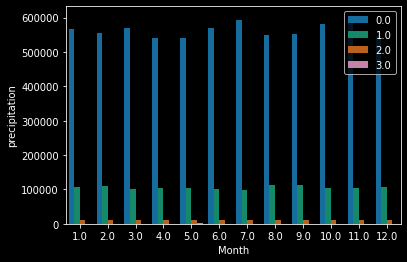

6191

In [0]:
# 강수량 > 0.1 일때 month 별 countplot
train_numeric[:,0] = train_numeric[:,0] // 100
sns.countplot(train_numeric[(train_numeric[:,3] >= 0.1), 4], hue = train_numeric[(train_numeric[:,3] >= 0.1), 0])
plt.ylabel('precipitation')
plt.xlabel('Month')
#plt.ylim(600000,730000)
plt.show()
gc.collect()

* 300 주변 구간에서 강수량 분포

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   2.,
          2.,   1.,   4.,  10.,   0.,  70., 178., 449., 573.]),
 array([295.5, 295.8, 296. , 296.2, 296.5, 296.5, 296.8, 297. , 297.2,
        297.5, 297.8, 298. , 298.2, 298.5, 298.8, 299. , 299. , 299.2,
        299.5, 299.8, 300. ], dtype=float16),
 <a list of 20 Patch objects>)

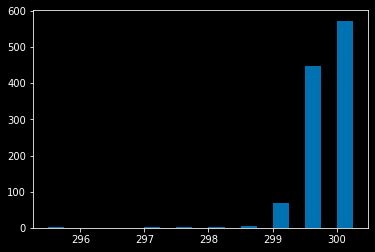

In [0]:
plt.hist(train_numeric[(train_numeric[:,3] > 295), 3], bins = 20)

In [0]:
len(train_numeric[train_numeric[:,3]> 298])/ len(train_numeric) * 100

0.0010519680398192416

In [0]:
pd.Seriextrain_numeric[(train_numeric[:,3] > 298), 3]

* 강수량 일부 구간에서 강수량 분포 시각화

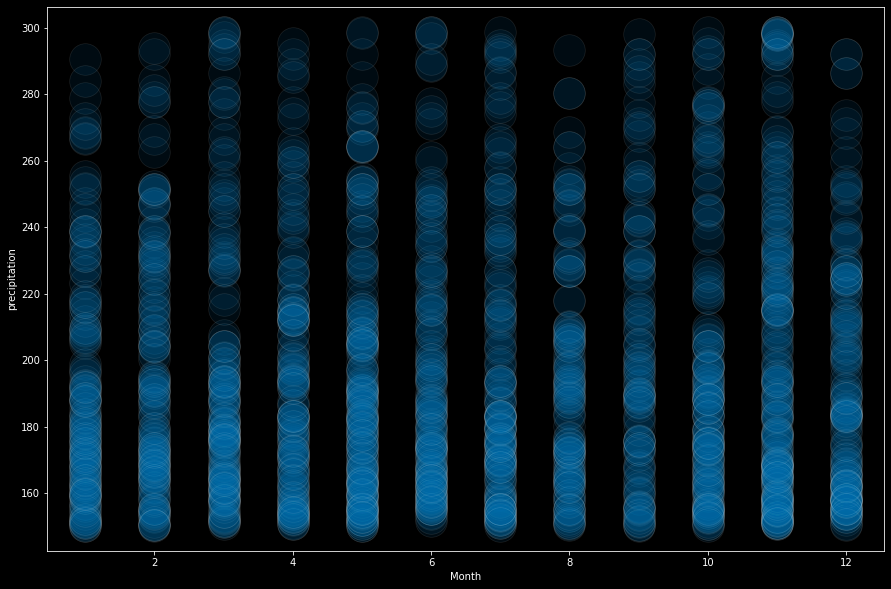

2457

In [0]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = train_numeric[((train_numeric[:,3] > 150) & (train_numeric[:,3] < 299)), 4],
                y = train_numeric[((train_numeric[:,3] > 150) & (train_numeric[:,3] < 299)), 3],
                alpha = 0.1,
                s = 1000)
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.show()
gc.collect()

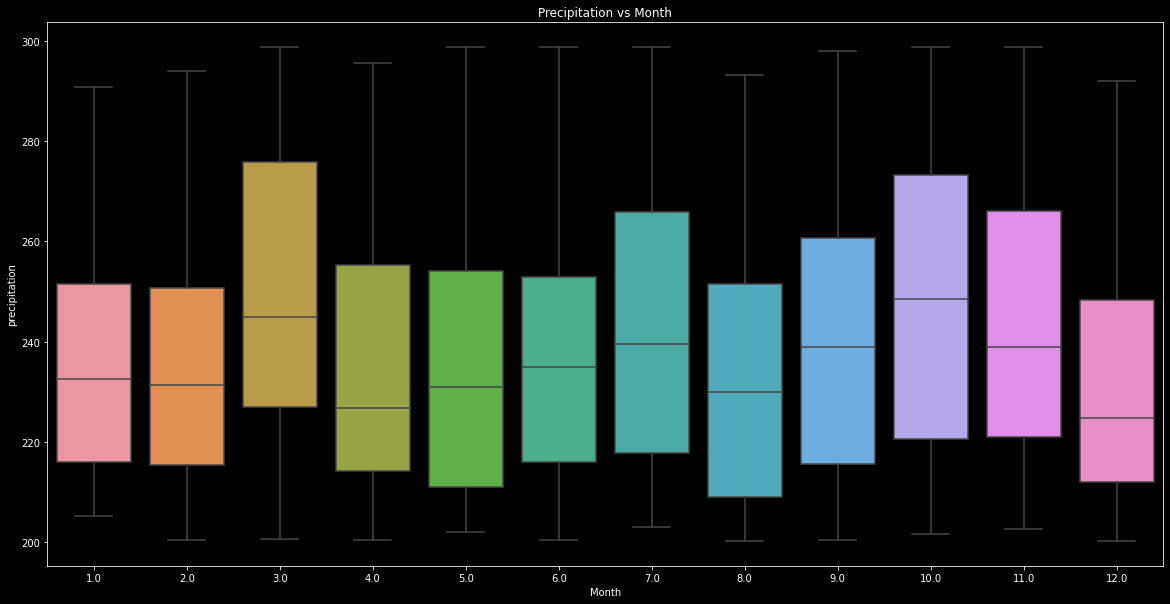

8507

In [0]:
plt.figure(figsize = (20,10))
sns.boxplot(x = train_numeric[((train_numeric[:,3] > 200) & (train_numeric[:,3] < 299)), 4],
            y = train_numeric[((train_numeric[:,3] > 200) & (train_numeric[:,3] < 299)), 3])

plt.ylabel('precipitation')
plt.xlabel('Month')
plt.title('Precipitation vs Month')
plt.show()
gc.collect()

* Feature별 histogram 그리기

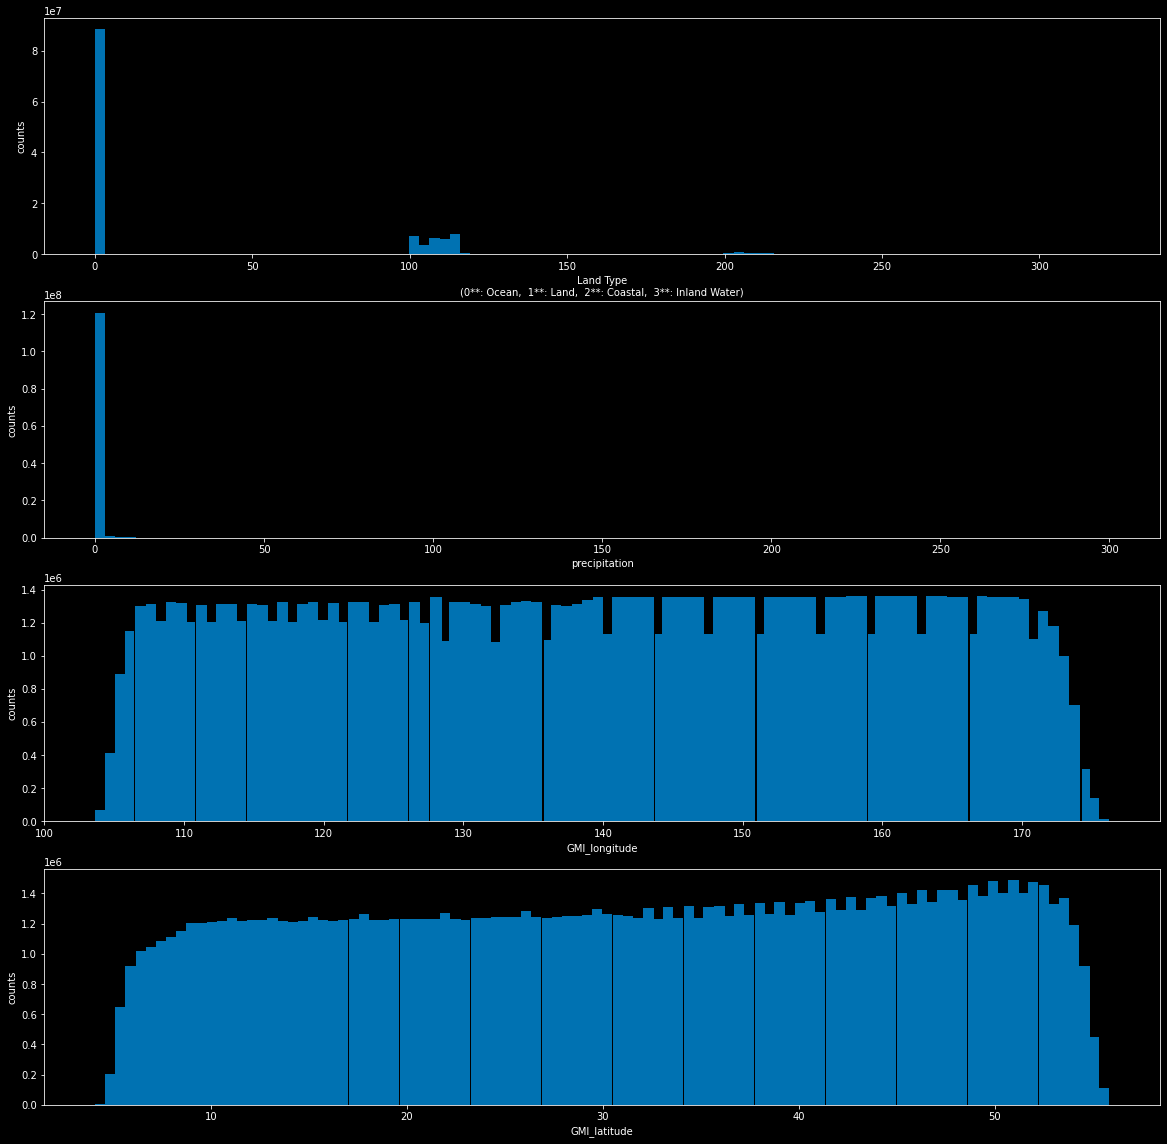

36114

In [0]:
plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
plt.hist(train_numeric[:,0], bins = 100)
#plt.ylim(0,2.0e7)
plt.ylabel('counts')
plt.xlabel('Land Type\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')

plt.subplot(4,1,2)
plt.hist(train_numeric[:,3], bins = 100)
#plt.ylim(0,0.1e8)
plt.ylabel('counts')
plt.xlabel('precipitation')

plt.subplot(4,1,3)
plt.hist(train_numeric[:,1], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_longitude')

plt.subplot(4,1,4)
plt.hist(train_numeric[:,2], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_latitude')

plt.show()
gc.collect()

* Feature별 histogram 그리기 ylim 조정

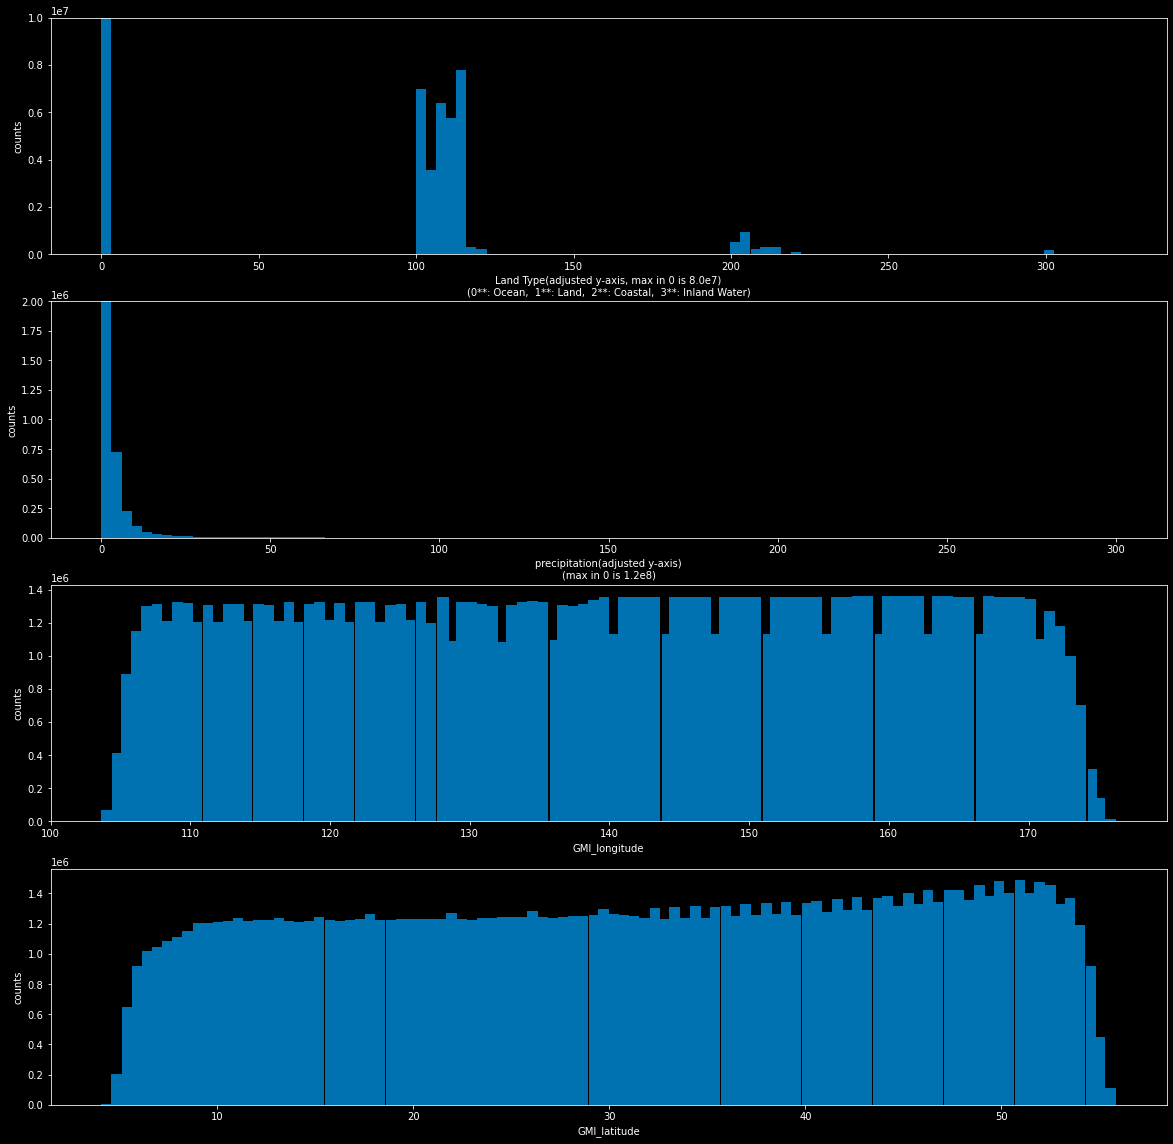

36203

In [0]:
plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
plt.hist(train_numeric[:,0], bins = 100)
plt.ylim(0,1.0e7)
plt.ylabel('counts')
plt.xlabel('Land Type(adjusted y-axis, max in 0 is 8.0e7)\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')

plt.subplot(4,1,2)
plt.hist(train_numeric[:,3], bins = 100)
plt.ylim(0,0.02e8)
plt.ylabel('counts')
plt.xlabel('precipitation(adjusted y-axis)\n(max in 0 is 1.2e8)')

plt.subplot(4,1,3)
plt.hist(train_numeric[:,1], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_longitude')

plt.subplot(4,1,4)
plt.hist(train_numeric[:,2], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_latitude')

plt.show()
gc.collect()

Text(0.5, 1.0, 'Satellite map')

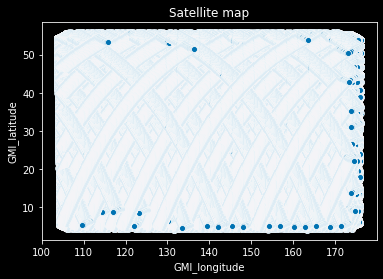

In [0]:
sns.scatterplot(train_numeric[:,1],train_numeric[:,2], alpha = 0.3)
plt.xlabel('GMI_longitude')
plt.ylabel('GMI_latitude')
plt.title('Satellite map')

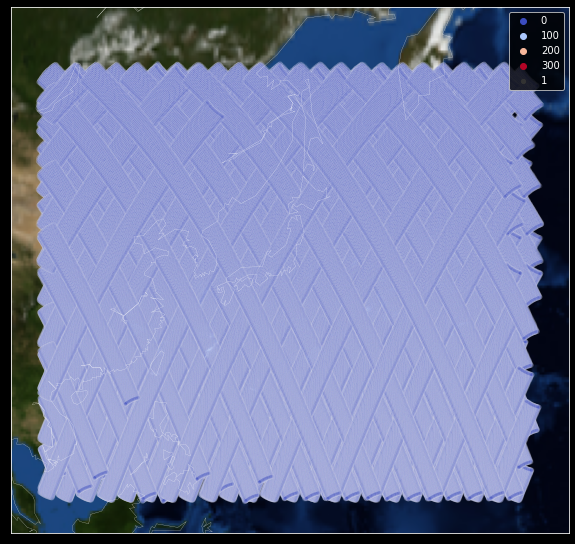

In [0]:
from mpl_toolkits.basemap import Basemap

gc.collect()
## 전체 데이터 지도위에 그리기
plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(train_numeric[:2000000,1], train_numeric[:2000000,2])  # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train_numeric[:2000000,3], # 크기는 Precipitation
                     palette=cmap,
                     size = 1,
                     #size=train_numeric_rain.precipitation, 
                     alpha = 0.1,
                     edgecolor = None
                     )
plt.show()


In [0]:
#강수 데이터 지도 위에 그리기
train_numeric_rain = train_numeric[(train_numeric[:,3] > 4)]
train_numeric_rain = train_numeric_rain[(train_numeric_rain[:,3] < 7)] 
train_numeric_rain.shape

(471098, 4)

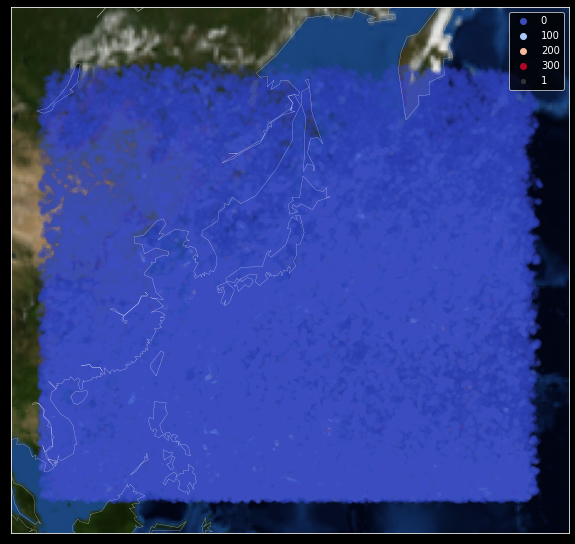

In [0]:

plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(train_numeric_rain[:,1], train_numeric_rain[:,2])  # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train_numeric_rain[:,3], # 색깔은 Land type
                     palette=cmap,
                     size = 1,
                     #size=train_numeric_rain.precipitation, # 크기는 Precipitation
                     alpha = 0.05,
                     edgecolor = None
                     )
plt.show()

In [0]:
train[1,0,:,11]

In [0]:
train_numeric

array([[  0.  , 159.5 ,   5.64,   0.  ,  12.  ],
       [  0.  , 159.5 ,   5.61,   0.  ,  12.  ],
       [  0.  , 159.6 ,   5.58,   0.  ,  12.  ],
       ...,
       [118.  , 115.5 ,  53.25,   0.  ,   1.  ],
       [115.  , 115.6 ,  53.22,   0.  ,   1.  ],
       [115.  , 115.7 ,  53.2 ,   0.  ,   1.  ]], dtype=float16)

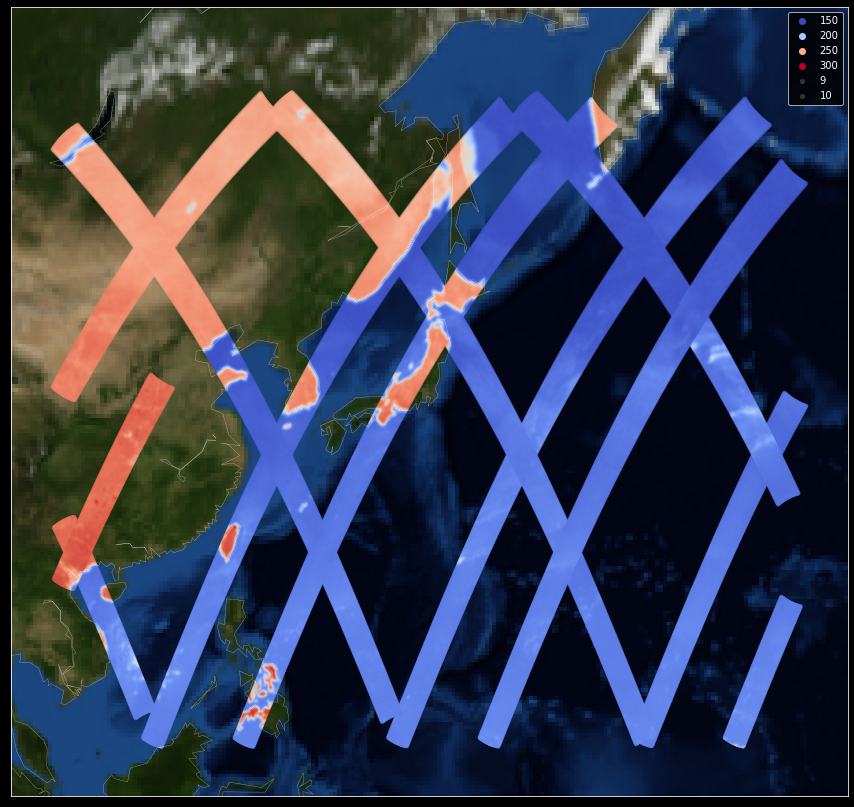

In [0]:
train_numeric_rain = train_numeric[train_numeric[:,3] > 2]
gc.collect()

plt.figure(figsize = (15,15))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines


x, y = m(train[:100,:,:,10].reshape(-1), train[:100,:,:,11].reshape(-1))   # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train[:100,:,:,0].reshape(-1), # 색깔은 channel0
                     palette = cmap,
                     #sizes=(1, 2000),
                     #color = 'red',
                     size=10,
                     alpha = 0.5,
                     linewidth=0
                     )

plt.show()


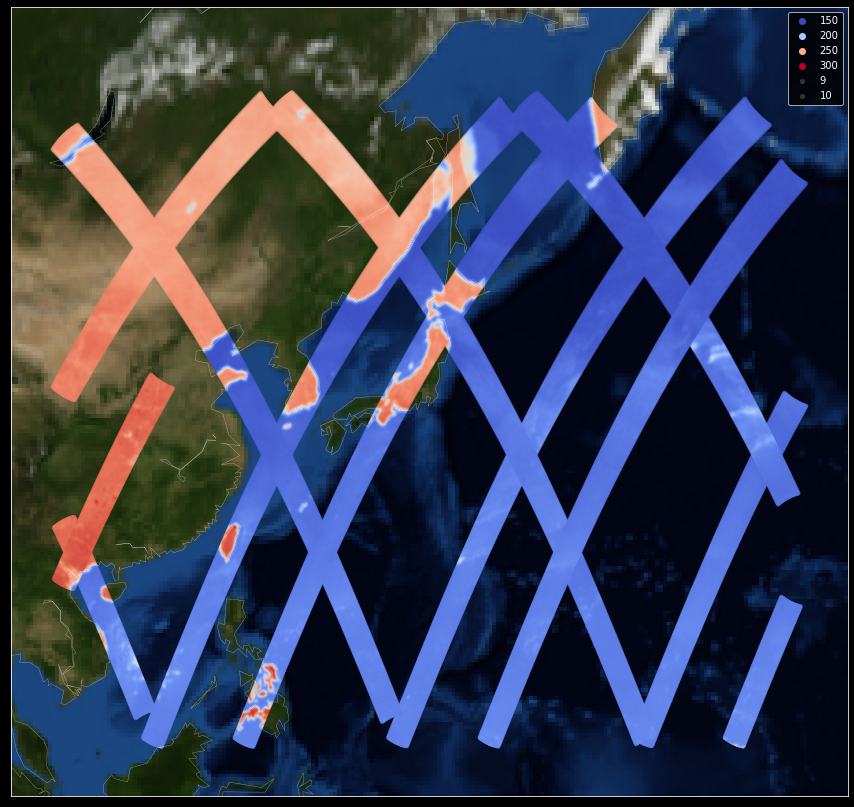

In [0]:
gc.collect()

plt.figure(figsize = (15,15))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines


x, y = m(train[:100,:,:,10].reshape(-1), train[:100,:,:,11].reshape(-1))   # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train[:100,:,:,0].reshape(-1), # 색깔은 channel0
                     palette = cmap,
                     #sizes=(1, 2000),
                     #color = 'red',
                     size=10,
                     alpha = 0.5,
                     linewidth=0
                     )

plt.show()


## 이미지 구간별 채널별 시각화

start : 시작인덱스
end : 마지막 인덱스
ch : 시각화 할 채널

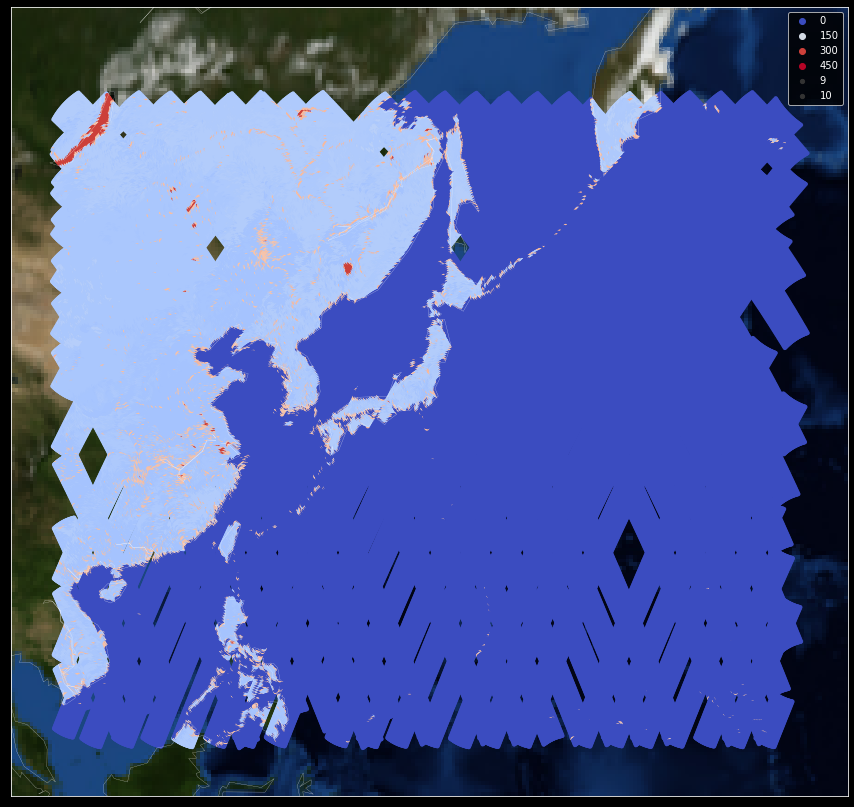

In [0]:
# 탐색할 채널 설정
ch = 9
start = 500
end = 1000
#-------------------------------------------------------------------------------
# 배경그리기
plt.figure(figsize = (15,15))
fig = plt.gcf()
m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')
m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
#-------------------------------------------------------------------------------
#이상치 이미지 앞 뒤로 100장 씩 그리기
x, y = m(train[start : end,:,:,10].reshape(-1), train[start : end,:,:,11].reshape(-1))   # transform coordinates
cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train[start : end,:,:,ch].reshape(-1), # 색깔은 channel0
                     palette = cmap,
                     #sizes=(1, 2000),
                     #color = 'red',
                     size=10,
                     alpha = 1,
                     linewidth=0
                     )
#-------------------------------------------------------------------------------


plt.show()


## 이상치 주변 분석

In [0]:
outlier_index = np.array([ 1011,  2536,  5229,  7616,  7787, 10530, 11399, 13175, 13779,
       16551, 21360, 22587, 24630, 27860, 27941, 28050, 29970, 30389,
       30475, 33520, 34534, 34944, 37548, 38213, 39155, 41866, 42806,
       43557, 45841, 46177, 46225, 49185, 51178, 57082, 58656, 60763,
       61366, 63588, 66096, 66375, 67073, 67445, 67861, 71221, 71535,
       71651, 73032, 74976, 75755])

In [0]:
outlier_index[0]

1011

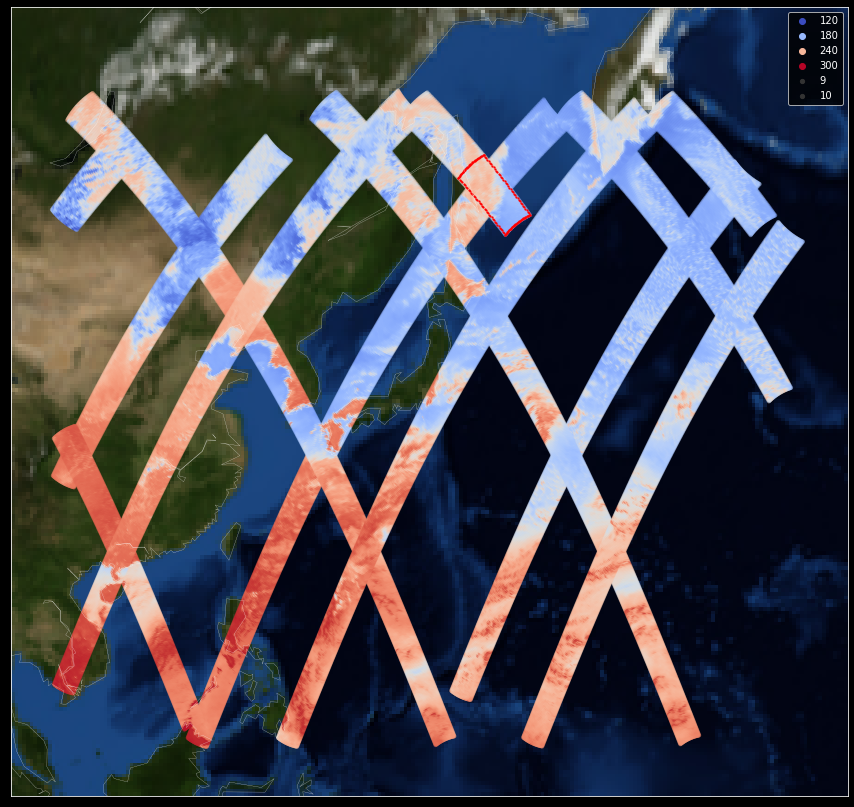

In [0]:
# 탐색할 이상치 데이터의 인덱스 설정
index = outlier_index[1]
# 탐색할 채널 설정
ch = 8

#-------------------------------------------------------------------------------
# 배경그리기
plt.figure(figsize = (15,15))
fig = plt.gcf()
m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')
m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
#-------------------------------------------------------------------------------
#이상치 이미지 인덱스 -100 부터 그리기
x, y = m(train[index - 100 : index + 1,:,:,10].reshape(-1), train[index - 100 : index + 1,:,:,11].reshape(-1))   # transform coordinates
cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train[index - 100 : index + 1,:,:,ch].reshape(-1), # 색깔은 channel0
                     palette = cmap,
                     #sizes=(1, 2000),
                     #color = 'red',
                     size=10,
                     alpha = 0.5,
                     linewidth=0
                     )
#-------------------------------------------------------------------------------
# 경계 추가하기
x_ow, y_ow = m(train[index,:,0,10], train[index,:,0,11])
x_uw, y_uw = m(train[index,:,39,10], train[index,:,39,11])
x_lh, y_lh = m(train[index,0,:,10], train[index,0,:,11])
x_rh, y_rh = m(train[index,39,:,10], train[index,39,:,11])

x_bound = np.concatenate([x_ow,x_uw, x_lh, x_rh])
y_bound = np.concatenate([y_ow,y_uw, y_lh, y_rh])

ax = sns.scatterplot(x=x_bound, y=y_bound,
                     color = 'red',
                     s = 5,
                     linewidth=0
                     )

plt.show()


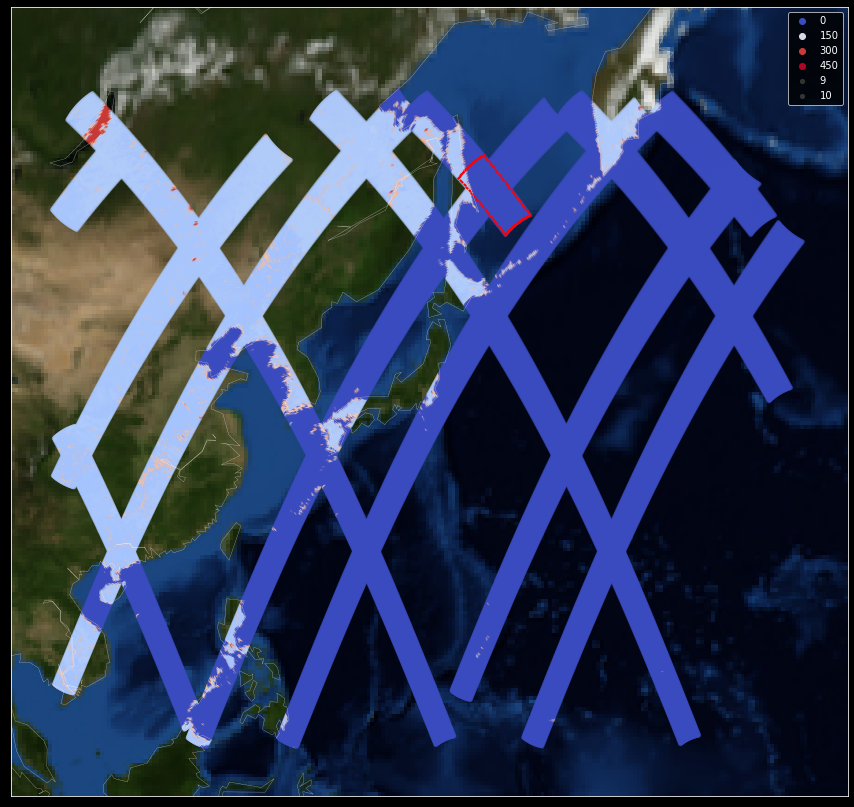

In [0]:
# 탐색할 이상치 데이터의 인덱스 설정
index = outlier_index[1]
# 탐색할 채널 설정
ch = 9

#-------------------------------------------------------------------------------
# 배경그리기
plt.figure(figsize = (15,15))
fig = plt.gcf()
m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')
m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
#-------------------------------------------------------------------------------
#이상치 이미지 인덱스 -100 부터 그리기
x, y = m(train[index - 100 : index + 1,:,:,10].reshape(-1), train[index - 100 : index + 1,:,:,11].reshape(-1))   # transform coordinates
cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train[index - 100 : index + 1,:,:,ch].reshape(-1), # 색깔은 channel0
                     palette = cmap,
                     #sizes=(1, 2000),
                     #color = 'red',
                     size=10,
                     alpha = 0.5,
                     linewidth=0
                     )
#-------------------------------------------------------------------------------
# 경계 추가하기
x_ow, y_ow = m(train[index,:,0,10], train[index,:,0,11])
x_uw, y_uw = m(train[index,:,39,10], train[index,:,39,11])
x_lh, y_lh = m(train[index,0,:,10], train[index,0,:,11])
x_rh, y_rh = m(train[index,39,:,10], train[index,39,:,11])

x_bound = np.concatenate([x_ow,x_uw, x_lh, x_rh])
y_bound = np.concatenate([y_ow,y_uw, y_lh, y_rh])

ax = sns.scatterplot(x=x_bound, y=y_bound,
                     color = 'red',
                     s = 5,
                     linewidth=0
                     )

plt.show()

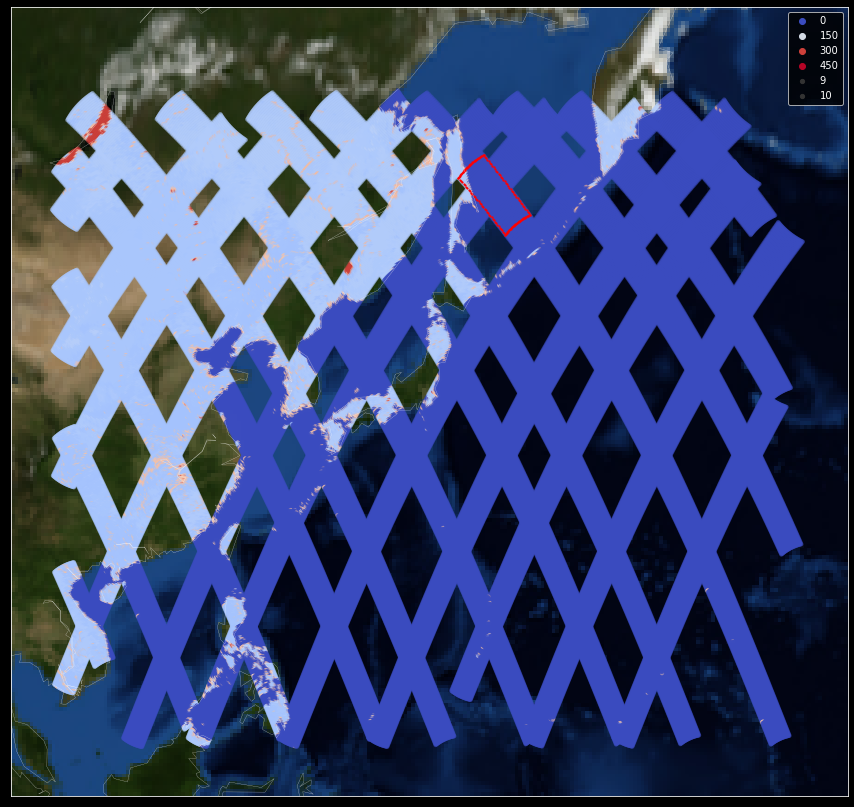

In [0]:
# 탐색할 이상치 데이터의 인덱스 설정
index = outlier_index[1]
# 탐색할 채널 설정
ch = 9

#-------------------------------------------------------------------------------
# 배경그리기
plt.figure(figsize = (15,15))
fig = plt.gcf()
m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')
m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
#-------------------------------------------------------------------------------
#이상치 이미지 앞 뒤로 100장 씩 그리기
x, y = m(train[index - 100 : index + 100,:,:,10].reshape(-1), train[index - 100 : index + 100,:,:,11].reshape(-1))   # transform coordinates
cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train[index - 100 : index + 100,:,:,ch].reshape(-1), # 색깔은 channel0
                     palette = cmap,
                     #sizes=(1, 2000),
                     #color = 'red',
                     size=10,
                     alpha = 0.5,
                     linewidth=0
                     )
#-------------------------------------------------------------------------------
# 경계 추가하기
x_ow, y_ow = m(train[index,:,0,10], train[index,:,0,11])
x_uw, y_uw = m(train[index,:,39,10], train[index,:,39,11])
x_lh, y_lh = m(train[index,0,:,10], train[index,0,:,11])
x_rh, y_rh = m(train[index,39,:,10], train[index,39,:,11])

x_bound = np.concatenate([x_ow,x_uw, x_lh, x_rh])
y_bound = np.concatenate([y_ow,y_uw, y_lh, y_rh])

ax = sns.scatterplot(x=x_bound, y=y_bound,
                     color = 'red',
                     s = 5,
                     linewidth=0
                     )

plt.show()


## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 11)) ## landtype추가, 월별 데이터 추가
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [0]:
train_month = train_orbit.month.values

In [0]:
gc.collect()
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for index, file in enumerate(train[train_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            if (cutoff_labels > 0).sum() < 50:
                continue
            feature = np.zeros((40,40,11))
            feature[:,:,:10] = file[:,:,:10]#########################land type, month 추가
            feature[:,:,-1] = train_month[train_index][index]############### month 추가

            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,11]),########################land type 추가, month 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
#-----------------------------------------------------------------------------
    def testGenerator():
        for index, file in enumerate(train[test_index]):
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = np.zeros((40,40,11))
            feature[:,:,:10] = file[:,:,:10]#########################land type, month 추가
            feature[:,:,-1] = train_month[test_index][index]############### month 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)

    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,11]),########################land type 추가, month 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
49/49 [==============================] - 44s 901ms/step - loss: 0.4182 - maeOverFscore_keras: 4.9837 - fscore_keras: 0.4193 - val_loss: 0.5660 - val_maeOverFscore_keras: 5.8921 - val_fscore_keras: 0.3291
Epoch 2/10
49/49 [==============================] - 41s 834ms/step - loss: 0.2936 - maeOverFscore_keras: 3.3614 - fscore_keras: 0.5416 - val_loss: 0.2916 - val_maeOverFscore_keras: 2.9192 - val_fscore_keras: 0.6059
Epoch 3/10
49/49 [==============================] - 41s 832ms/step - loss: 0.2853 - maeOverFscore_keras: 3.1318 - fscore_keras: 0.5648 - val_loss: 0.2828 - val_maeOverFscore_keras: 2.8595 - val_fscore_keras: 0.6066
Epoch 4/10
49/49 [==============================] - 41s 833ms/step - loss: 0.2780 - maeOverFscore_keras: 2.8961 - fscore_keras: 0.5940 - val_loss: 0.3017 - val_maeOverFscore_keras: 4.1025 - val_fscore_keras: 0.4638
Epoch 5/10
49/49 [==============================] - 41s 832ms/step - loss: 0.2705 - maeOverFscore_keras: 2.6802 - fscore_keras: 0.62

In [0]:
## 모델 저장하기
model.save('model_landtype_month.h5')
!cp model_landtype_month.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

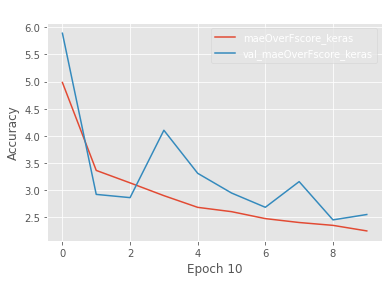

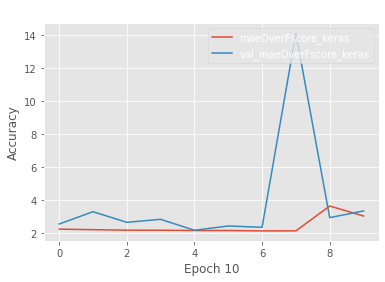

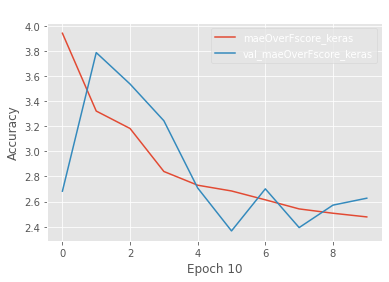

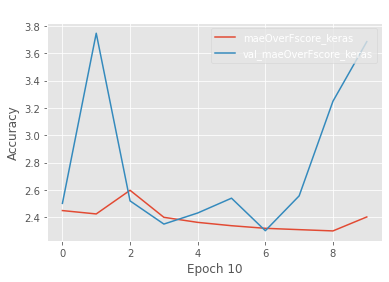

In [0]:
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')


## submission 만들기

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_submit = test_submit[:,:,:,:10]
del test_submit
gc.collect()
pred = model.predict(test_submit)

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'